# Candidate Generator
Creates a list of candidates. The file is saved to `data/candidates.csv`.

In [1]:
import re
from numpy.random import default_rng
from faker import Faker

MAX_CANDIDATES = 400
UCID_PREFIX = 'DT'
START_ID = UCID_PREFIX + '0000'
PADDING_LEN = 4

# CEFR: (theta, probability)
THETA_DIST_L = {
    "Smattering": (-6.49, 0.02),
    "Pre-A1": (-5.39, 0.02),
    "A1": (-4.29, 0.06),
    "A2": (-3.23, 0.06),
    "A2+": (-2.21, 0.17),
    "B1": (-1.23, 0.17),
    "B1+": (-0.26, 0.17),
    "B2": (0.72, 0.17),
    "B2+": (1.74, 0.06),
    "C1": (2.80, 0.06),
    "C2": (3.90, 0.02),
    "Mastery": (5.10, 0.02)
}

# create a distribution of theta abilities for all the candidates
distr = list(THETA_DIST_L.values())
flat_distr = [item for j in [[i[0]] * int(i[1]*100) for i in distr] for item in j]
rng = default_rng()
theta_idx = rng.integers(100, size=MAX_CANDIDATES)


def getRandomTheta(c: int) -> float:
    '''
    Returns a previously generated theta value from the flat_distr list
    
    Parameters:
        c (int): the candidate index (0..MAX_CANDIDATES)

    Returns:
        cefr (str): the corresponding CEFR looked up from THETA_DIST_L
    '''
    return flat_distr[theta_idx[c]]


def getCEFR(theta: float) -> str:
    '''
    Given a theta (ability), perform a lookup to get the corresponding
    CEFR value

    Parameters:
        theta (float): the candidate's ability

    Returns:
        cefr (str): the corresponding CEFR looked up from THETA_DIST_L,
        or None if there is no match
    '''
    cefr = {k:v for k,v in THETA_DIST_L.items() if v[0] == theta}
    cefrValue = list(cefr.keys())
    if len(cefrValue) == 1:
        return(cefrValue[0])
    else:
        return None
    

def getRandomCandidateName(f):
    genders = ['F', 'M']
    rng = default_rng()
    g_idx = rng.integers(len(genders))
    if genders[g_idx] == 'F':
        givenName = f.first_name_female()
        familyName = f.last_name_female()
    elif genders[g_idx] == 'M':
        givenName = f.first_name_male()
        familyName = f.last_name_male()
    else:
        givenName = f.first_name_nonbinary()
        familyName = f.last_name_nonbinary()

    return (givenName, familyName)
    

def incrementCandidate(ucid: str = None) -> str:
    '''
    Returns the next candidate ID.

    Parameters:
        ucid (str): a unique candidate ID of the form `DT0001`

    Returns:
        nextUcid (str): a unique candidate ID of the form `DT0001`
    '''
    if ucid is None:
        return UCID_PREFIX + '0001'
    
    m = re.search(r'\d+', ucid)
    if m is None:
        raise Exception(
            "Unique candidate identifer (ucid) must contain a number")

    id = int(m.group(0))
    if (id >= 0):
        id = id + 1
    else:
        raise Exception("""Unique candidate identifier (ucid) must be a number greater than
                        or equal to 0""")

    nextUcid = UCID_PREFIX + str(id).zfill(PADDING_LEN)
    return nextUcid


## Create the Randomised Set
First we create the randomised set of candidates (as a list of tuples), with $\theta$ values taken from the distribution in `THETA_DIST_L`.

In [2]:
# generate a list for tuples containing the candidate info:
# (ucid, theta, estimated_cefr)
# ('DT0001', -1.5, 'A1.1')
#

candidates = []
fake = Faker('es_ES')   # see https://faker.readthedocs.io/en/master/locales.html for possible locales
ucid = START_ID
for c in range(0, MAX_CANDIDATES):
    ucid = incrementCandidate(ucid)
    theta = getRandomTheta(c)
    estimated_cefr = getCEFR(theta)
    name = getRandomCandidateName(fake)
    rand_cand = (ucid, ) + name + (theta, estimated_cefr)
    candidates.append(rand_cand)

## Write to File
Finally we write out to the CSV data file.

In [3]:
import csv

with open('data/candidates.csv', 'w', newline='') as csvfile:
    candidate_writer = csv.writer(csvfile)
    candidate_writer.writerow(('systemname', 'givenName', 'familyName', 'Theta', 'CEFR'))
    for c in candidates:
        candidate_writer.writerow(c)

In [4]:
!head data/candidates.csv

## Distribution
We can create a distribution map from the list of candidates to show their abilities:

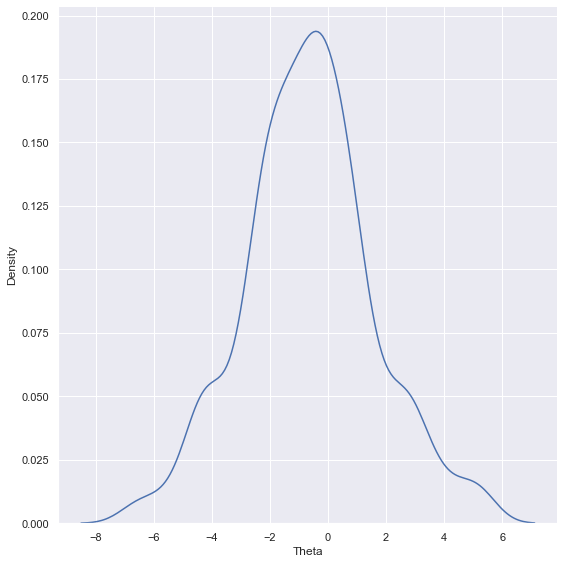

In [5]:
%matplotlib inline

import seaborn as sns
import pandas

# Apply the default theme
sns.set_theme()

candidates = pandas.read_csv('data/candidates.csv')
sns.displot(candidates, x="Theta", kind="kde", height=8)